In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import wandb

# Log in to wandb with API key
wandb.login(key='eb4c4a1fa7eec1ffbabc36420ba1166f797d4ac5')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split



In [ ]:
# Define paths for training, validation, and test sets
train_img_path = '/content/drive/MyDrive/crater/craters/train/images'
train_lbl_path = '/content/drive/MyDrive/crater/craters/train/labels'
valid_img_path = '/content/drive/MyDrive/crater/craters/valid/images'
valid_lbl_path = '/content/drive/MyDrive/crater/craters/valid/labels'
test_img_path = '/content/drive/MyDrive/crater/craters/test/images'
test_lbl_path = '/content/drive/MyDrive/crater/craters/test/labels'
model_path = '/content/drive/MyDrive/crater/best.pt'
data_yaml_path = '/content/drive/MyDrive/crater/crater_data.yaml'


In [ ]:
# EDA and Data Preprocessing
def load_labels(label_path):
    label_files = os.listdir(label_path)
    data = []
    classes = set()
    for file in label_files:
        with open(os.path.join(label_path, file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = list(map(float, line.strip().split()))
                data.append([file, *parts])
                classes.add(int(parts[0]))
    df = pd.DataFrame(data, columns=['file', 'class', 'x_center', 'y_center', 'width', 'height'])
    return df, sorted(classes)

train_labels, train_classes = load_labels(train_lbl_path)
valid_labels, valid_classes = load_labels(valid_lbl_path)
test_labels, test_classes = load_labels(test_lbl_path)

In [ ]:
# Get all unique classes
all_classes = sorted(set(train_classes + valid_classes + test_classes))
class_names = [f'class_{i}' for i in all_classes]

In [ ]:
# Display first few rows of the labels
print("Train Labels")
print(train_labels.head())
print("\nValidation Labels")
print(valid_labels.head())
print("\nTest Labels")
print(test_labels.head())

Train Labels
                                              file  class  x_center  y_center  \
0  012_png.rf.64da6ff4c62638096ee6e5bf689706bc.txt    0.0  0.516406  0.067187   
1  012_png.rf.64da6ff4c62638096ee6e5bf689706bc.txt    0.0  0.392969  0.717969   
2  012_png.rf.64da6ff4c62638096ee6e5bf689706bc.txt    0.0  0.310156  0.079687   
3  012_png.rf.64da6ff4c62638096ee6e5bf689706bc.txt    0.0  0.886719  0.818750   
4  012_png.rf.64da6ff4c62638096ee6e5bf689706bc.txt    0.0  0.602344  0.832812   

      width    height  
0  0.048438  0.042969  
1  0.142187  0.134375  
2  0.018750  0.025000  
3  0.018750  0.025781  
4  0.239844  0.321094  

Validation Labels
                                                file  class  x_center  \
0  mars_crater--13-_jpg.rf.f6fc01f728dfec8b32ad59...    0.0  0.264844   
1  mars_crater--13-_jpg.rf.f6fc01f728dfec8b32ad59...    0.0  0.340625   
2  mars_crater--13-_jpg.rf.f6fc01f728dfec8b32ad59...    0.0  0.436719   
3  mars_crater--13-_jpg.rf.f6fc01f728dfec8b32

In [ ]:
# Create data.yaml
data_yaml_content = f"""
train: {train_img_path}
val: {valid_img_path}
test: {test_img_path}

nc: {len(all_classes)}  # number of classes
names: {class_names}  # class names
"""

with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

In [ ]:
# Plotting distribution of bounding box sizes
def plot_bounding_box_distribution(labels, title):
    labels['area'] = labels['width'] * labels['height']
    fig = px.histogram(labels, x='area', nbins=50, title=title)
    fig.show()

plot_bounding_box_distribution(train_labels, 'Train Bounding Box Area Distribution')
plot_bounding_box_distribution(valid_labels, 'Validation Bounding Box Area Distribution')
plot_bounding_box_distribution(test_labels, 'Test Bounding Box Area Distribution')

In [ ]:
# Image Preprocessing and Visualization
def visualize_sample_images(image_path, label_df, n_samples=5):
    image_files = os.listdir(image_path)[:n_samples]
    for img_file in image_files:
        img_path = os.path.join(image_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img)

        labels = label_df[label_df['file'] == img_file]
        for _, label in labels.iterrows():
            x_center = label['x_center'] * img.shape[1]
            y_center = label['y_center'] * img.shape[0]
            width = label['width'] * img.shape[1]
            height = label['height'] * img.shape[0]
            x_min = x_center - width / 2
            y_min = y_center - height / 2

            rect = plt.Rectangle(
                (x_min, y_min), width, height,
                edgecolor='red', facecolor='none', linewidth=2
            )
            ax.add_patch(rect)

        plt.title(f'Sample Image: {img_file}')
        plt.axis('off')
        plt.show()

# Call the visualization function for train, validation, and test sets
visualize_sample_images(train_img_path, train_labels)
visualize_sample_images(valid_img_path, valid_labels)
visualize_sample_images(test_img_path, test_labels)


In [ ]:
# YOLOv8 Model Training and Evaluation
!pip install -q ultralytics
from ultralytics import YOLO


In [ ]:
# Import necessary libraries
import os
import cv2
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the model and move it to the device
model = YOLO('yolov8n.pt').to(device)

# Train the model on the device
model.train(data=data_yaml_path, epochs=50, device=device)

# Evaluate the model
results = model.val()

# Save the trained model
model.save('/content/drive/MyDrive/crater/craters/best_model.pt')

# Visualize sample detections
def visualize_detections(model, image_path, n_samples=10):
    image_files = os.listdir(image_path)[:n_samples]
    for img_file in image_files:
        img_path = os.path.join(image_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Perform inference on the device
        results = model(img_path, device=device)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img)

        for result in results[0].boxes:
            x_min, y_min, x_max, y_max = result.xyxy[0].cpu().numpy()
            conf = result.conf[0].cpu().item()
            rect = plt.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                edgecolor='red', facecolor='none', linewidth=2
            )
            ax.add_patch(rect)
            ax.text(
                x_min, y_min, f'{conf:.2f}',
                bbox=dict(facecolor='yellow', alpha=0.5)
            )

        plt.title(f'Detection in: {img_file}')
        plt.axis('off')
        plt.show()

# Call the visualization function
visualize_detections(model, test_img_path)

print("Model training, evaluation, and sample visualization completed. The trained model is saved at '/content/drive/MyDrive/crater/craters/best_model.pt'.")


In [ ]:
# Load the trained YOLO model and fine-tune it
from ultralytics import YOLO
model = YOLO('/content/drive/MyDrive/crater/craters/best_model.pt')

# Fine-tune with more epochs and possibly a lower learning rate
model.train(data=data_yaml_path, epochs=20, lr0=0.0001, device=device)

# Evaluate the fine-tuned model
results = model.val()

# Save the fine-tuned model
model.save('/content/drive/MyDrive/crater/craters/fine_tuned_model.pt')


In [ ]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor
from datasets import load_dataset

# Load the pre-trained DETR model
detr_model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')

# Fine-tune on your dataset
# Assuming you have the images and annotations formatted correctly
# You will need to prepare the dataset to match the COCO format
def detr_fine_tune(images, annotations):
    inputs = processor(images=images, annotations=annotations, return_tensors="pt")
    outputs = detr_model(**inputs)

    loss = outputs.loss
    loss.backward()

    # Perform optimizer step, etc.
    # Fine-tuning loop here...

# Save the fine-tuned DETR model
detr_model.save_pretrained('/content/drive/MyDrive/crater/craters/detr_fine_tuned')

In [ ]:
test_img_path = '/content/drive/MyDrive/crater/craters/test/images'

In [ ]:
import os
test_img_path = '/content/drive/MyDrive/crater/craters/test/images'
image_files = os.listdir(test_img_path)
print(image_files)  # This should list the images in the folder

In [ ]:
for img_file in image_files:
    img_path = os.path.join(test_img_path, img_file)
    yolo_results = model(img_path, device=device)

    # Visualize YOLO predictions
    visualize_detections(model, test_img_path, n_samples=5)

In [ ]:
train_img_path = '/content/drive/MyDrive/crater/craters/train/images'

In [ ]:
import os
train_img_path = '/content/drive/MyDrive/crater/craters/train/images'
image_files = os.listdir(train_img_path)
print(image_files)  # This should list the images in the folder

In [ ]:
for img_file in image_files:
    img_path = os.path.join(train_img_path, img_file)
    yolo_results = model(img_path, device=device)

    # Visualize YOLO predictions
    visualize_detections(model, train_img_path, n_samples=5)

In [ ]:
valid_img_path = '/content/drive/MyDrive/crater/craters/valid/images'

In [ ]:
import os
valid_img_path = '/content/drive/MyDrive/crater/craters/valid/images'
image_files = os.listdir(valid_img_path)
print(image_files)  # This should list the images in the folder

In [ ]:
for img_file in image_files:
    img_path = os.path.join(valid_img_path, img_file)
    yolo_results = model(img_path, device=device)

    # Visualize YOLO predictions
    visualize_detections(model, valid_img_path, n_samples=2)

In [ ]:
!zip -r run.zip /content/runs


In [34]:
from google.colab import files
files.download("run.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r crater.zip /content/drive/MyDrive/crater

In [36]:
!cp -r /content/runs /content/drive/MyDrive/runs



image 1/1 /content/Screenshot 2024-11-03 094525.png: 640x608 10 class_0s, 264.9ms
Speed: 4.4ms preprocess, 264.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


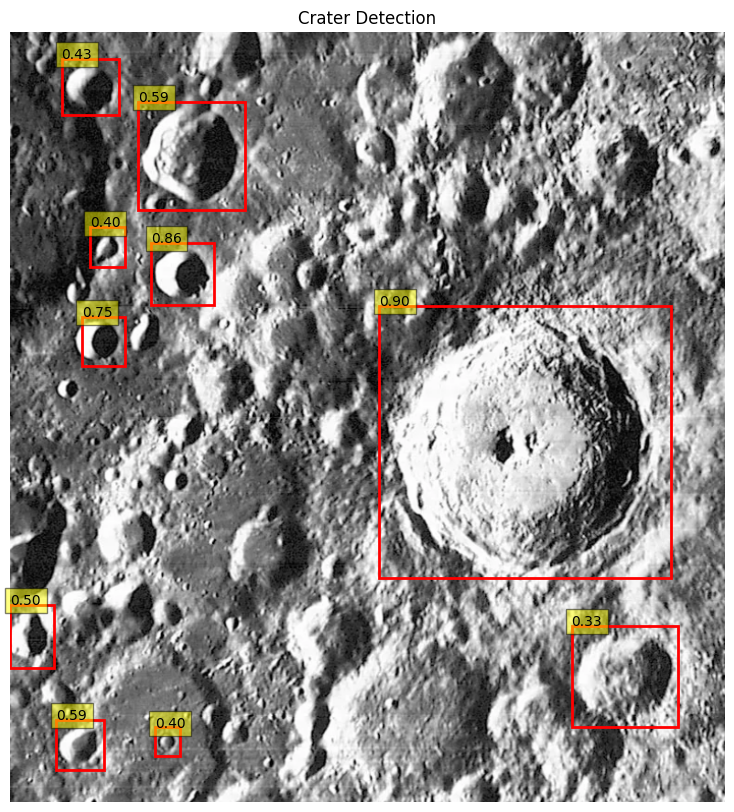

In [37]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Step 1: Load the trained model
model_path = '/content/drive/MyDrive/crater/craters/best_model.pt'  # Adjust this path if needed
model = YOLO(model_path)

# Step 2: Specify the path for the new image
new_image_path = '/content/Screenshot 2024-11-03 094525.png'  # Replace with the actual path of the image to test

# Step 3: Run inference on the new image
results = model(new_image_path)

# Step 4: Visualize detection results
# Load the image using OpenCV and convert to RGB
img = cv2.imread(new_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the image with bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img)

# Iterate over each detection result to plot bounding boxes
for result in results[0].boxes:
    x_min, y_min, x_max, y_max = result.xyxy[0].cpu().numpy()
    conf = result.conf[0].cpu().item()

    # Plot bounding box
    rect = plt.Rectangle(
        (x_min, y_min), x_max - x_min, y_max - y_min,
        edgecolor='red', facecolor='none', linewidth=2
    )
    ax.add_patch(rect)
    ax.text(
        x_min, y_min, f'{conf:.2f}',
        bbox=dict(facecolor='yellow', alpha=0.5)
    )

plt.title("Crater Detection")
plt.axis("off")
plt.show()
